# Определение параметров, создание датасета


In [27]:
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image


# Путь к директориям с изображениями и метками
image_train_dir = "/train/"
image_test_dir = "/test/"
image_query_dir = "image_query/"
train_label_file = "train_label.xml"
test_label_file = "test_label.xml"

# Загрузка меток обучающих данных
train_labels = {}
with open(train_label_file, 'r') as f:
    for line in f:
        if 'imageName' in line:
            image_name = line.split('"')[1]
            type_id = line.split('"')[9]
            label = {'type_id': type_id}
            train_labels[image_name] = label
# Загрузка меток тестовых данных
test_labels = {}
with open(test_label_file, 'r') as f:
    for line in f:
        if 'imageName' in line:
            image_name = line.split('"')[1]
            type_id = line.split('"')[9]
            label = {'type_id': type_id}
            test_labels[image_name] = label



In [28]:
# обычно

transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([254,254]),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)


train_dataset = datasets.ImageFolder('./train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.ImageFolder('./test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
criterion = nn.CrossEntropyLoss()

In [29]:
# АУГМЕНТАЦИЯ
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize([254,254]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Resize([254,254]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = datasets.ImageFolder('./train/', transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.ImageFolder('./test/', transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = nn.CrossEntropyLoss()

# Процесс обучения модели на 4 классах

## Модель Resnet18

In [24]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4) # Заменяем последний полносвязный слой на слой с 4 выходами

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Выбор оптимизатора, подключение к видеокарте

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CrossEntropyLoss()

### Процесс обучения

In [34]:
#train_losses = []
#test_losses = []

for epoch in range(7):
    train_loss = 0.0
    test_loss = 0.0

    # Обучение на train_loader
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация на val_loader
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

    
# Сохранение модели
torch.save(model.state_dict(), 'classification_resnet18_2.pth')
#model.load_state_dict(torch.load('classification_resnet.pth'))

Epoch 1, Train Loss: 0.03984954398318429, Test Loss: 2.532701424483275
Epoch 2, Train Loss: 0.07168524951837493, Test Loss: 2.028913642885976
Epoch 3, Train Loss: 0.09690634628716839, Test Loss: 2.2677579917515307
Epoch 4, Train Loss: 0.03015991401504969, Test Loss: 2.6308797846253302
Epoch 5, Train Loss: 0.05195854157057077, Test Loss: 1.8109477634664783
Epoch 6, Train Loss: 0.03466826892896741, Test Loss: 2.595042449015743
Epoch 7, Train Loss: 0.02476511692523794, Test Loss: 1.9781335523152292


In [35]:
train_losses, test_losses

([0.34272632299168154,
  0.17607023870928717,
  0.09022223846132398,
  0.03984954398318429,
  0.07168524951837493,
  0.09690634628716839,
  0.03015991401504969,
  0.05195854157057077,
  0.03466826892896741,
  0.02476511692523794],
 [1.5127824178508986,
  2.018330705470575,
  1.8999142574327545,
  2.532701424483275,
  2.028913642885976,
  2.2677579917515307,
  2.6308797846253302,
  1.8109477634664783,
  2.595042449015743,
  1.9781335523152292])

Построение кривой обучения

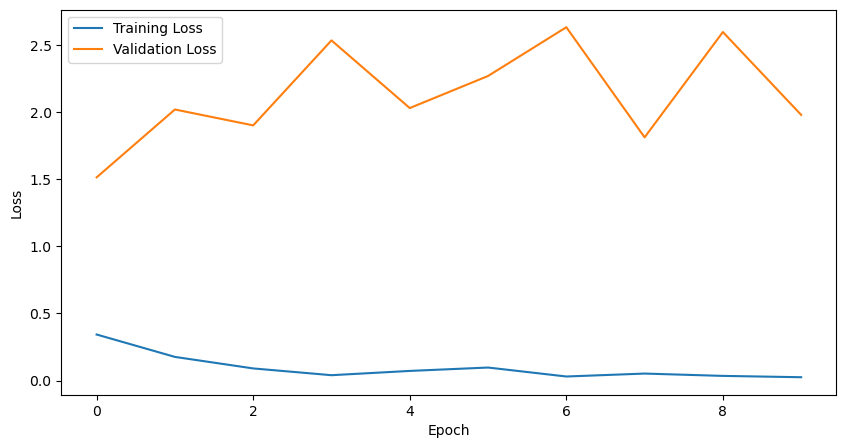

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Отображение предсказанных классов

NameError: name 'dataset' is not defined

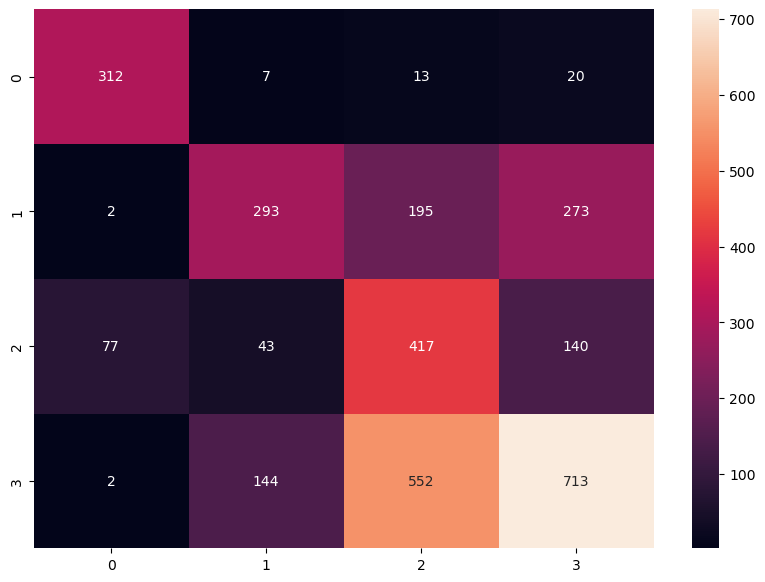

In [41]:
# Вывод матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xticks(np.arange(10)+0.5, dataset.classes, rotation=45)
plt.yticks(np.arange(10)+0.5, dataset.classes, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params}")

Количество обучаемых параметров: 11178564


In [9]:
model.load_state_dict(torch.load('classification_resnet18.pth'))

<All keys matched successfully>

In [38]:
from sklearn.metrics import f1_score, accuracy_score
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [36]:
# Проверка на тестовом множестве

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        max_values, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.detach().cpu()) 
        y_pred.extend(predicted.detach().cpu())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f'Test Accuracy: {acc}')
    print(f'Test F1 Score: {f1}')

Test Accuracy: 0.5416796753044021
Test F1 Score: 0.578476716794829


Теперь точность модели ResNet18 равна 54-57%. Это значительное выше предыдущего значения в 10%, когда модель совершенно не могла распознавать классы.
Это значит, что редактирование обучающей выборки и снижение обучаемых классов напрямую влияет на точность

## Модель VGG16

In [17]:
from torchvision.models import vgg16

model = vgg16(pretrained=True)

In [18]:
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CrossEntropyLoss()

In [19]:
for param in model.parameters():
    param.requires_grad = False
for layer in model.classifier:
    layer.requires_grad = True

In [20]:
num_classes = 4
in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features, num_classes)

In [21]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params}")
optimizer = optim.Adam(model.parameters(), lr=0.001)

Количество обучаемых параметров: 16388


In [22]:
train_losses = []
test_losses = []

for epoch in range(7):
    train_loss = 0.0
    test_loss = 0.0

    # Обучение на train_loader
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация на val_loader
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

    
# Сохранение модели
torch.save(model.state_dict(), 'classification_vgg16_2.pth')
#model.load_state_dict(torch.load('classification_resnet.pth'))

Epoch 1, Train Loss: 0.23919344981928004, Test Loss: 1.2168647657308793
Epoch 2, Train Loss: 0.1547839369651882, Test Loss: 1.5840489903738968
Epoch 3, Train Loss: 0.14072724430643807, Test Loss: 1.8681837632796934
Epoch 4, Train Loss: 0.13231607492475442, Test Loss: 1.6892341193406288
Epoch 5, Train Loss: 0.11586979032145414, Test Loss: 1.8648668507583197
Epoch 6, Train Loss: 0.11932353836420166, Test Loss: 2.2672358893480458
Epoch 7, Train Loss: 0.12935226125669208, Test Loss: 2.067217315791031


In [25]:
# Проверка на тестовом множестве

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        max_values, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.detach().cpu()) 
        y_pred.extend(predicted.detach().cpu())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f'Test Accuracy: {acc}')
    print(f'Test F1 Score: {f1}')

Test Accuracy: 0.5778957227599126
Test F1 Score: 0.6012396704137281


После редактирования данных, предобученная модель VGG16 показала точность примерно 57-60%, что при таком наборе данных является довольно неплохим показателем



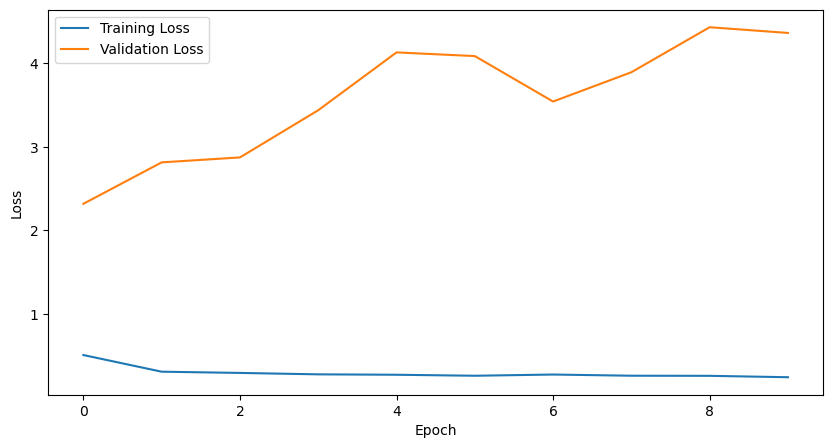

In [103]:
# Построение кривой обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'dataset' is not defined

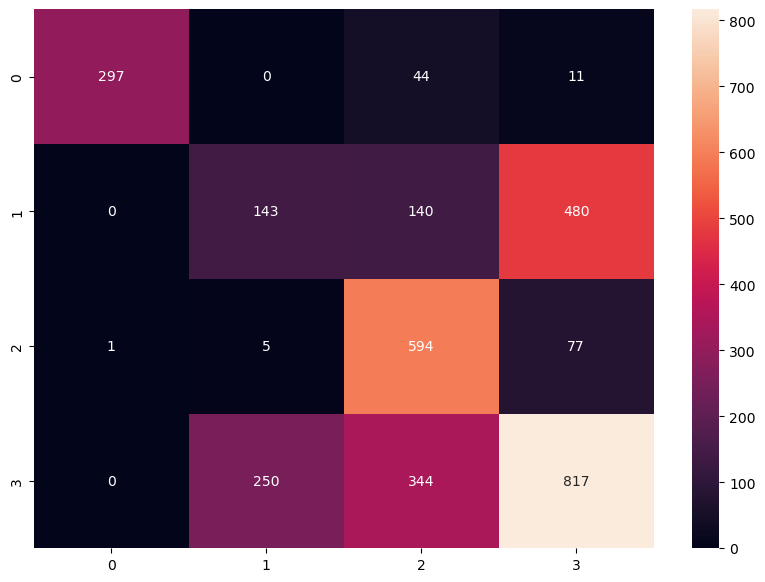

In [26]:
# Вывод матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xticks(np.arange(10)+0.5, dataset.classes, rotation=45)
plt.yticks(np.arange(10)+0.5, dataset.classes, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Мы видим, что нулевой класс определяется хорошо. Однако возникают сложности при классификации 2 и 3 видов. Это может быть связано со схожестью самих типов автомобилей

## Вывод:

Среди моделей наилучший результат показала модель VGG16. Поэтому в дальнейшем тестировании будем использовать ее.

# Теперь протестируем VGG16 на других данных. Разобьем данные на 3 класса.

In [30]:
from torchvision.models import vgg16

model = vgg16(pretrained=True)

D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CrossEntropyLoss()

In [42]:
for param in model.parameters():
    param.requires_grad = False
for layer in model.classifier:
    layer.requires_grad = True

In [43]:
num_classes = 3
in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features, num_classes)

In [44]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params}")
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Количество обучаемых параметров: 12291


In [48]:
train_losses = []
test_losses = []

for epoch in range(1):
    train_loss = 0.0
    test_loss = 0.0

    # Обучение на train_loader
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация на val_loader
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

    
# Сохранение модели
torch.save(model.state_dict(), 'classification_vgg16_3.pth')
#model.load_state_dict(torch.load('classification_resnet.pth'))

Epoch 1, Train Loss: 0.2324383208611398, Test Loss: 2.6550173956871035


In [49]:
# Проверка на тестовом множестве

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        max_values, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.detach().cpu()) 
        y_pred.extend(predicted.detach().cpu())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f'Test Accuracy: {acc}')
    print(f'Test F1 Score: {f1}')

Test Accuracy: 0.4468
Test F1 Score: 0.4416028155179377


В рамках последнего теста данные были разбиты на 3 группы: пикапы, седаны, и остальные автомобили.
Однако такое разбиение не позволило повысить точность. На данный момент точность равна 44-45%.